# Fit Real Data with Basic SIR Model

**Author: Veronica Scerra**  
**Last Updated: 2025-10-15**

**Purpose:**
Fit SIR to OWID daily incidence for one country

**Inputs & Dependencies:**
- Code: `src/dataio/load_owid_covid.py`, `src/epimodels/sir.py`, `src/epimodels/fitting.py`
- Libraries: `numpy`, `matplotlib`, `pandas`  
- Covid19 data pulled from OWID

**Outputs:**
- Baseline SIR fit to data
- Piecewise SIR fit to data based on variable transmission rates 

**Context:**
Fourth notebook in the **SIR Model Project**, serving as a means for applying the SIR model fitting to a slice of real world data.

### Import paths and dependencies

In [2]:
import sys, os, numpy as np, pandas as pd, matplotlib.pyplot as plt
sys.path.append(os.path.abspath(os.path.join("..", "src")))
from dataio.loaders import load_owid_covid
from epimodels.fitting import fit_beta_gamma

### Load data from one country

In [7]:
country = "United States"
df = load_owid_covid(country, source="compact", start="2020-09-01", end="2021-03-01", smooth=7)
df.head(), df.tail(), df.shape

(        date  t  incidence  incidence_smooth   population
 0 2020-09-01  0    36635.0      41790.000000  341534041.0
 1 2020-09-02  1    38696.0      41554.571429  341534041.0
 2 2020-09-03  2    39178.0      42179.000000  341534041.0
 3 2020-09-04  3    43647.0      42210.571429  341534041.0
 4 2020-09-05  4    45272.0      41868.000000  341534041.0,
           date    t  incidence  incidence_smooth   population
 177 2021-02-25  177    70162.0      66535.857143  341534041.0
 178 2021-02-26  178    72358.0      66934.142857  341534041.0
 179 2021-02-27  179    71998.0      66354.428571  341534041.0
 180 2021-02-28  180    73274.0      65682.000000  341534041.0
 181 2021-03-01  181    68298.0      63339.000000  341534041.0,
 (182, 5))

### Choose the observed series and model grid

In [ ]:
# observed series (incidence with light smoothing)
y_obs = df["incidence_smooth"].to_numpy()
t = df["t"].to_numpy().astype(float)
N = int(df["population"].iloc[0])

# initial infected guess (small, >0)
I0 = max(10, int(0.0005 * N)) # you can tune this 

# Bounds: infectious period 5-14 days -> gamma in [1/14, 1/5]
beta_bounds = (0.05, 0.8)
gamma_bounds = (1/14, 1/5)

### Fit $\beta$, $\gamma$ (observable = incidence)

In [9]:
res = fit_beta_gamma(
    t=t, 
    y_obs=y_obs,
    N=N,
    I0=I0,
    R0_init=0,
    observable="incidence",
    beta_bounds=beta_bounds,
    gamma_bounds=gamma_bounds,
    grid_size=(25, 25),
    refine=True,
    init_step=(0.02, 0.02),
    random_restarts=3
)

res

{'beta': 0.2375,
 'gamma': 0.19464285714285717,
 'R0': 1.220183486238532,
 'loss': 413096999.1003329,
 'scale': 0.1958259707979377,
 'y_fit': array([     0.        ,   8109.71861181,   8462.53340153,   8830.38426701,
          9213.8839648 ,   9613.66770227,  10030.39372906,  10464.74392146,
         10917.42435662,  11389.16587355,  11880.72461709,  12392.88256113,
         12926.44800677,  13482.25605064,  14061.16901815,  14664.07685627,
         15291.8974796 ,  15945.57706301,  16626.09027397,  17334.44043644,
         18071.65961824,  18838.80863278,  19636.97694548,  20467.28247443,
         21330.87127458,  22228.91709311,  23162.62078388,  24133.20956735,
         25141.93612211,  26190.07749282,  27278.93379929,  28409.82673003,
         29584.09780309,  30803.10637669,  32068.22739067,  33380.84882002,
         34742.36882072,  36154.19254781,  37617.72862547,  39134.3852484 ,
         40705.56589416,  42332.66462584,  44017.06096529,  45760.11431746,
         47563.15792727

### Plot fit vs. data

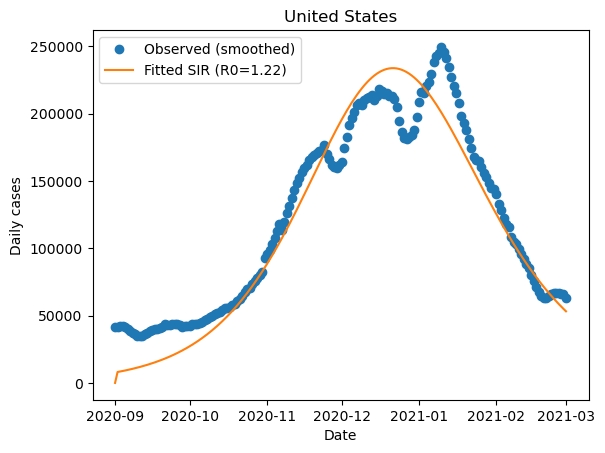

In [10]:
plt.figure()
plt.plot(df["date"], y_obs, marker='o', linestyle='', label='Observed (smoothed)')
plt.plot(df["date"], res["y_fit"], label=f"Fitted SIR (R0={res['R0']:.2f})")
plt.ylabel("Daily cases"); plt.xlabel("Date"); plt.legend(); plt.title(country)
plt.show()

### Inspect trajectories at fitted params

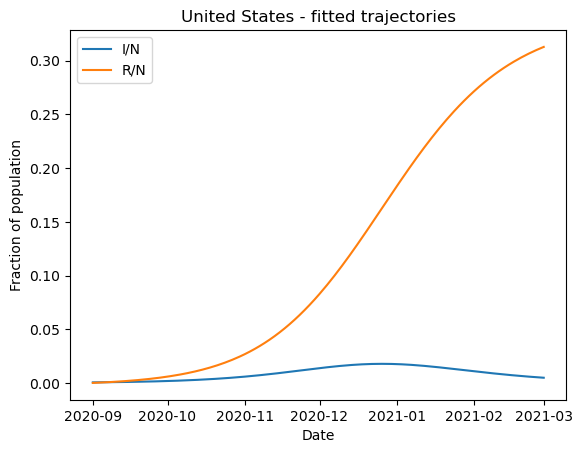

In [11]:
sim = res['sim']
plt.figure()
plt.plot(df["date"], sim["I"]/N, label="I/N")
plt.plot(df["date"], sim["R"]/N, label="R/N")
plt.ylabel("Fraction of population"); plt.xlabel("Date"); plt.legend()
plt.title(f"{country} - fitted trajectories")
plt.show()

### Assess fit

In [ ]:
from sklearn.metrics import root_mean_squared_error
rmse = root_mean_squared_error(y_obs, res["y_fit"])
peak_day_err = df.loc[np.argmax(y_obs), "date"] - df.loc[np.argmax(res["y_fit"]), "date"]
print(f"RMSE: {rmse:,.1f}  |  Peak day error: {peak_day_err}")


RMSE: 20,324.8  |  Peak day error: 19 days 00:00:00


: 

## Refit the data with piecewise beta values to reflect varying transmission rates

In [ ]:
from epimodels.fitting import fit_piecewise_beta

# build segments by date
breaks = ["2020-03-01", "2020-10-01", "2021-03-01", "2021-06-01"] #start...end
edges = df.set_index("date").index.astype("datetime64[ns]")

# convert to t-units
edge_vals = [float(df.loc[df["date"] >= np.datetime64(d)].iloc[0]["t"]) for d in breaks]
# ensure unique and sorted; also ensure first/last match window
edge_vals[0] = float(df["t"].iloc[0])
edge_vals[-1] = float(df["t"].iloc[-1])
edges_t = np.array(edge_vals, dtype=float)

y_obs = df["incidence_smooth"].to_numpy()
t = df["t"].astype(float).to_numpy()
N = int(df["population"].iloc[0])
I0 = max(10, int(0.0005 * N))

res_pw = fit_piecewise_beta(
   t=t, y_obs=y_obs, N=N, I0=I0,
    edges=edges_t,
    observable="incidence",
    beta_bounds=(0.05, 1.2),
    gamma_bounds=(1/14, 1/5),
    lambda_smooth=0.0,      # try 1e-3 to discourage big jumps
    grid_gamma=15,
    step_beta=0.03,
    step_gamma=0.01
)
res_pw

{'betas': array([0.244375, 0.394375, 0.68625 ]),
 'gamma': 0.2,
 'R0_segments': array([1.221875, 1.971875, 3.43125 ]),
 'loss': 3717505586.011024,
 'scale': 0.10345221913295943,
 'y_fit': array([     0.        ,   4411.62710078,   4610.50729132,   4818.17166627,
          5034.99135523,   5261.35159753,   5497.65212944,   5744.30756672,
          6001.7477807 ,   6270.41826537,   6550.78049316,   6843.31225669,
          7148.50799333,   7466.87908943,   7798.95416039,   8145.27930278,
          8506.41831408,   8882.95287526,   9275.48269126,   9684.62558367,
         10111.01752963,  10555.31264063,  11018.18307402,  11500.31887001,
         12002.42770603,  12525.23455994,  13069.48127318,  13635.92600391,
         14225.34256031,  14838.51960303,  15476.25970556,  16139.37826068,
         16828.7022207 ,  17545.06865842,  18289.32313575,  19062.31786616,
         19864.90965707,  20697.95761779,  21562.32061877,  22458.85448776,
         23388.40892849,  24351.82414805,  25349.9271

### Plot the piecewise fit

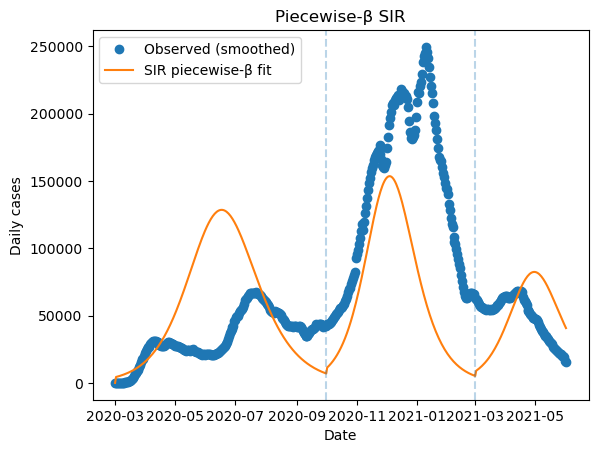

Segment R0 values: [1.22 1.97 3.43]


In [9]:
plt.figure()
plt.plot(df["date"], y_obs, marker='o', linestyle='', label="Observed (smoothed)")
plt.plot(df["date"], res_pw["y_fit"], label="SIR piecewise-β fit")
for x in res_pw["edges"][1:-1]:  # vertical lines at internal boundaries
    plt.axvline(df.loc[df["t"]==x, "date"].iloc[0], alpha=0.3, linestyle="--")
plt.ylabel("Daily cases"); plt.xlabel("Date"); plt.legend(); plt.title("Piecewise-β SIR")
plt.show()

print("Segment R0 values:", np.round(res_pw["R0_segments"], 2))